In [5]:
from nbed.utils import (
    pubchem_mol_geometry,
    build_ordered_xyz_string,
    save_ordered_xyz_file,
)

fm = pubchem_mol_geometry("fluoromethane")


In [6]:
fm

{0: ('F', (0.6783, 0, 0)),
 1: ('C', (-0.6783, 0, 0)),
 2: ('H', (-1.0293, 0.464, 0.9239)),
 3: ('H', (-1.0293, 0.5681, -0.8639)),
 4: ('H', (-1.0293, -1.0322, -0.0601))}

In [7]:
pfoa_ordered = build_ordered_xyz_string(pfoa, active_atom_inds=[0,1])
save_ordered_xyz_file("CH3F", pfoa, active_atom_inds=[0,1])

'/Users/michaelwilliamsdelabastida/Code/Nbed/docs/notebooks/molecular_structures/CH3F.xyz'

In [8]:
from math import sqrt
import numpy as np
from pyscf import gto, scf, cc, fci, dft
import matplotlib.pyplot as plt
from nbed.driver import NbedDriver

In [9]:
def find_distance(r1, r2):
    return sqrt((r2[0]-r1[0])**2 + (r2[1]-r1[1])**2 + (r2[2]-r1[2])**2)

def find_point(r1, r2, d):
    R = find_distance(r1, r2)
    r2p = [r1[0] + (r2[0]-r1[0])*d/R, r1[1] + (r2[1]-r1[1])*d/R, r1[2] + (r2[2]-r1[2])*d/R]
    r2m = [r1[0] - (r2[0]-r1[0])*d/R, r1[1] - (r2[1]-r1[1])*d/R, r1[2] - (r2[2]-r1[2])*d/R]
    return r2p

def edit_xyz(filename, atom1_line_num, atom2_line_num, length, precision):
    with open(filename, 'r') as file:
        readlines = file.readlines()

    # ignoring white space so ['atom', 'x', 'y', 'z']
    atom1_line = readlines[atom1_line_num - 1].split()
    atom2_line = readlines[atom2_line_num - 1].split()

    print('fixed  atom: ', atom1_line)
    print('moving atom: ', atom2_line)

    # extracted xyz coordinates of atom 1 and 2:
    r1 = [float(atom1_line[1]), float(atom1_line[2]), float(atom1_line[3])]
    r2 = [float(atom2_line[1]), float(atom2_line[2]), float(atom2_line[3])]

    new_coords = find_point(r1, r2, length)
    new_line = atom2_line
    for i in range(3):
        new_line[i + 1] = str(round(new_coords[i], precision))

    new_line.append('\n')

    readlines[atom2_line_num - 1] = '    '.join(new_line)

    print('new coords : ', new_line)

    with open(filename, 'w') as file:
        file.writelines(readlines)

    with open(filename, 'r') as file:
        readlines = file.readlines()
    
    return readlines

In [38]:
filename = 'molecular_structures/CH3F.xyz'
basis = 'sto-3g'
atom1_line_num = 4
atom2_line_num = 3
precision = 4
run_HF = False
run_CCSD = False
run_FCI = True

run_DFT = True
run_did = False

run_Nbed = True
active_atoms = 2

lengths = np.arange(0.85, 2.35, 0.10)
print(len(lengths), '\n')

hf_energies = np.zeros(len(lengths))
ccsd_energies = np.zeros(len(lengths))
fci_energies = np.zeros(len(lengths))
nbed_energies = np.zeros(len(lengths))
dft_energies = np.zeros(len(lengths))
did_energies = np.zeros(len(lengths))

nbed_config = {
    "geometry" : filename,
    "n_active_atoms" : active_atoms,
    "basis" : basis,
    "xc_functional" : "b3lyp",
    "projector" : "mu",
    "localization" : "spade",
    "convergence" : 1e-6,
    "run_virtual_localization" : True,
    "run_ccsd_emb" : False,
    "run_fci_emb" : True,
    "run_dft_in_dft": run_did,
}

for i in range(len(lengths)):
    print("%.2f" % lengths[i])
    data = edit_xyz(filename, atom1_line_num, atom2_line_num, length = lengths[i], precision = precision)
    print()

    mol = gto.M(atom = filename, basis = basis, spin = 0, charge = 0)

    #HF
    if run_HF:
        mf = scf.RHF(mol).run()
        hf_energies[i] = mf.e_tot
        print('e_nuc = ', mf.energy_nuc())


    #CCSD
    if run_CCSD:
        mf = scf.HF(mol).run()
        mycc = cc.CCSD(mf).run()
        ccsd_energies[i] = mycc.e_tot

    # FCI
    if run_FCI:
        myhf = mol.RHF().run()
        cisolver = fci.FCI(myhf)
        fci_energies[i] = cisolver.kernel()[0]

    # KSDFT
    if run_DFT:
        mf = dft.RKS(mol)
        mf.xc = nbed_config["xc_functional"]
        mf.kernel()
        dft_energies[i]=mf.e_tot

    # Nbed
    if run_Nbed:
        driver = NbedDriver(**nbed_config)
        nbed_energies[i] = driver._mu["e_fci"]

        if run_did:
            did_energies[i] = driver._mu["e_dft_in_dft"]

    print()

# CH3F STO-3G run with FCI: 2m 44.4s

# CH3F 6-31G run without FCI: 10.6s
# CH3F cc-pvdz run without FCI: 34.0s


# mol1 sto-3g HF only: 11m 9.8s

15 

0.85
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '1.5717', '0.0', '0.0']
new coords :  ['F', '0.1717', '0.0', '0.0', '\n']

converged SCF energy = -136.277247811962


converged SCF energy = -136.912586543715


Initialize <pyscf.gto.mole.Mole object at 0x2d1c370a0> in <pyscf.dft.rks.RKS object at 0x2d1c36fb0>



0.95
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.1717', '0.0', '0.0']
new coords :  ['F', '0.2717', '0.0', '0.0', '\n']

converged SCF energy = -136.708334372182
converged SCF energy = -137.337397115994


Initialize <pyscf.gto.mole.Mole object at 0x2d1f9abf0> in <pyscf.dft.rks.RKS object at 0x2d1f9ab60>



1.05
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.2717', '0.0', '0.0']
new coords :  ['F', '0.3717', '0.0', '0.0', '\n']

converged SCF energy = -136.948967464024
converged SCF energy = -137.573490548049


Initialize <pyscf.gto.mole.Mole object at 0x2d1c98a30> in <pyscf.dft.rks.RKS object at 0x2d1c983d0>



1.15
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.3717', '0.0', '0.0']
new coords :  ['F', '0.4717', '0.0', '0.0', '\n']

converged SCF energy = -137.079045013883
converged SCF energy = -137.701177620733


Initialize <pyscf.gto.mole.Mole object at 0x2d1c36e00> in <pyscf.dft.rks.RKS object at 0x2d1c370a0>



1.25
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.4717', '0.0', '0.0']
new coords :  ['F', '0.5717', '0.0', '0.0', '\n']

converged SCF energy = -137.143031623063
converged SCF energy = -137.765391351662


Initialize <pyscf.gto.mole.Mole object at 0x2d1f9a8f0> in <pyscf.dft.rks.RKS object at 0x2d1f9ae90>



1.35
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.5717', '0.0', '0.0']
new coords :  ['F', '0.6717', '0.0', '0.0', '\n']

converged SCF energy = -137.166615297521
converged SCF energy = -137.792011724008


Initialize <pyscf.gto.mole.Mole object at 0x2d1f9bee0> in <pyscf.dft.rks.RKS object at 0x2d1f9ae90>



1.45
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.6717', '0.0', '0.0']
new coords :  ['F', '0.7717', '0.0', '0.0', '\n']

converged SCF energy = -137.164884803585
converged SCF energy = -137.795937136326


Initialize <pyscf.gto.mole.Mole object at 0x2d1f9aaa0> in <pyscf.dft.rks.RKS object at 0x2d1f99540>



1.55
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.7717', '0.0', '0.0']
new coords :  ['F', '0.8717', '0.0', '0.0', '\n']

converged SCF energy = -137.147021284503
converged SCF energy = -137.785850593294


Initialize <pyscf.gto.mole.Mole object at 0x2d1c351e0> in <pyscf.dft.rks.RKS object at 0x2d1c36e00>



1.65
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.8717', '0.0', '0.0']
new coords :  ['F', '0.9717', '0.0', '0.0', '\n']

converged SCF energy = -137.119039209395
converged SCF energy = -137.767130599206


Initialize <pyscf.gto.mole.Mole object at 0x2d1fafe20> in <pyscf.dft.rks.RKS object at 0x2d1fadd80>



1.75
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '0.9717', '0.0', '0.0']
new coords :  ['F', '1.0717', '0.0', '0.0', '\n']

converged SCF energy = -137.085211742463
converged SCF energy = -137.74342718921


Initialize <pyscf.gto.mole.Mole object at 0x2d1faf5e0> in <pyscf.dft.rks.RKS object at 0x2d1fafe20>



1.85
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '1.0717', '0.0', '0.0']
new coords :  ['F', '1.1717', '0.0', '0.0', '\n']

converged SCF energy = -137.04869102636
converged SCF energy = -137.71736516777


Initialize <pyscf.gto.mole.Mole object at 0x2d1fafdc0> in <pyscf.dft.rks.RKS object at 0x2d1c351e0>



1.95
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '1.1717', '0.0', '0.0']
new coords :  ['F', '1.2717', '0.0', '0.0', '\n']

converged SCF energy = -137.011754477827
converged SCF energy = -137.690816816551


Initialize <pyscf.gto.mole.Mole object at 0x2d1f9b970> in <pyscf.dft.rks.RKS object at 0x2d1f9abf0>



2.05
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '1.2717', '0.0', '0.0']
new coords :  ['F', '1.3717', '0.0', '0.0', '\n']

converged SCF energy = -136.975948205464
converged SCF energy = -137.665039996435


Initialize <pyscf.gto.mole.Mole object at 0x2d1d98970> in <pyscf.dft.rks.RKS object at 0x2d1f99300>



2.15
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '1.3717', '0.0', '0.0']
new coords :  ['F', '1.4717', '0.0', '0.0', '\n']

converged SCF energy = -136.942234422072
converged SCF energy = -137.640806893738


Initialize <pyscf.gto.mole.Mole object at 0x2d1f9aaa0> in <pyscf.dft.rks.RKS object at 0x2d1f992a0>



2.25
fixed  atom:  ['C', '-0.6783', '0', '0']
moving atom:  ['F', '1.4717', '0.0', '0.0']
new coords :  ['F', '1.5717', '0.0', '0.0', '\n']

converged SCF energy = -136.911148315002
converged SCF energy = -137.618539483672


Initialize <pyscf.gto.mole.Mole object at 0x2ca907460> in <pyscf.dft.rks.RKS object at 0x2ca906ec0>


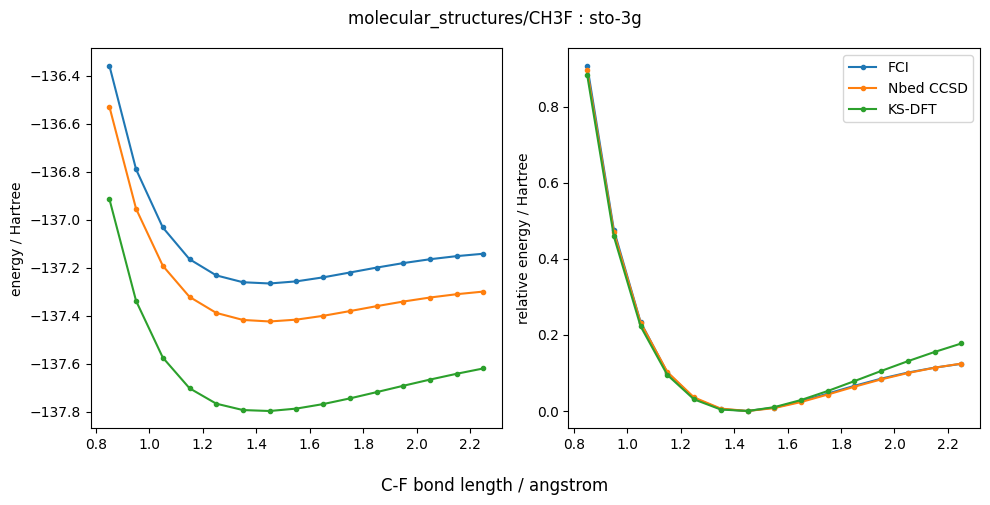

In [39]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = False, figsize = (10,5))

if run_HF:
    ax0.plot(lengths, hf_energies, label = 'HF', marker = '.')
    ax1.plot(lengths, hf_energies - np.min(hf_energies), label = 'HF', marker = '.')
if run_CCSD:
    ax0.plot(lengths, ccsd_energies, label = 'CCSD', marker = '.')
    ax1.plot(lengths, ccsd_energies - np.min(ccsd_energies), label = 'CCSD', marker = '.')
if run_FCI:
    ax0.plot(lengths, fci_energies, label = 'FCI', marker = '.')
    ax1.plot(lengths, fci_energies - np.min(fci_energies), label = 'FCI', marker = '.')
if run_Nbed:
    ax0.plot(lengths, nbed_energies, label = 'Nbed CCSD', marker = '.')
    ax1.plot(lengths, nbed_energies - np.min(nbed_energies), label = 'Nbed CCSD', marker = '.')
if run_DFT:
    ax0.plot(lengths, dft_energies, label = 'KS-DFT', marker = '.')
    ax1.plot(lengths, dft_energies - np.min(dft_energies), label = 'KS-DFT', marker = '.')
if run_did:
    ax0.plot(lengths, did_energies, label = 'DFT-in-DFT', marker = '.')
    ax1.plot(lengths, did_energies - np.min(did_energies), label = 'DFT-in-DFT', marker = '.')
ax0.set_ylabel('energy / Hartree')
ax1.set_ylabel('relative energy / Hartree')
fig.suptitle(' '.join([filename[0:-4], ":", basis]))
fig.supxlabel('C-F bond length / angstrom')
plt.legend()
plt.tight_layout()
plt.show()

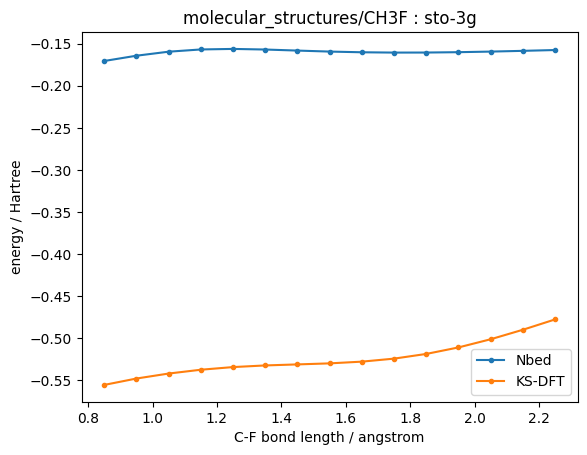

In [40]:
if run_HF:
    plt.plot(lengths, hf_energies - fci_energies, label = 'HF', marker = '.')
if run_CCSD:
    plt.plot(lengths, ccsd_energies - fci_energies, label = 'CCSD', marker = '.')
if run_Nbed:
    plt.plot(lengths, nbed_energies - fci_energies, label = 'Nbed', marker = '.')
if run_DFT:
    plt.plot(lengths, dft_energies - fci_energies, label = 'KS-DFT', marker = '.')
plt.xlabel('C-F bond length / angstrom')
plt.ylabel('energy / Hartree')
plt.title(' '.join([filename[0:-4], ":", basis]))
plt.legend()
plt.show()